In [82]:
import sys
sys.path.append("..")
# libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from hydropt.iops import ThreeCompModel_OLCI, OLCI_WBANDS
from hydropt.hydropt import PolynomialForward
from ipywidgets import interactive
import itertools
import tqdm

In [111]:
plt.rcParams['figure.figsize'] = (12,10)
plt.style.use('ggplot')

In [3]:
fwd_model = PolynomialForward(ThreeCompModel_OLCI())

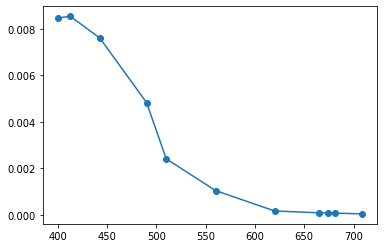

In [10]:
plt.plot(OLCI_WBANDS, fwd_model.forward(chl=1E-2, nap=1E-2, cdom=1E-2), marker='o')

In [12]:
path = '/Users/tadzio/Documents/code_repo/hydropt_4_sent3/data/interim/D20190813_141238_OLCI_SUNTHETA_30/*.nc'
ds = xr.open_mfdataset(path, combine='by_coords')

In [14]:
ds_subset = ds.isel(geom_depth=0, suntheta=0, geom_depth_air=0, phi=0, fmu=9)

In [56]:
def plot_rrs(chl, cdom, nap):
    data = ds_subset.sel(Chl=chl, CDOM=cdom, NAP=nap)
    rrs_hl = (data.RADMa/data.Ed).values
    rrs_hd = fwd_model.forward(chl=chl, cdom=cdom, nap=nap)
    plt.plot(OLCI_WBANDS, rrs_hl/rrs_hd)
    plt.ylim(.9,1.1)
    #plt.plot(OLCI_WBANDS, rrs_hd)

In [58]:
def interactive_rrs():
    interactive_plot = interactive(plot_rrs, 
                                   cdom=ds_subset.CDOM.values, 
                                   nap=ds_subset.NAP.values, 
                                   chl=ds_subset.Chl.values)
    output = interactive_plot.children[-1]
    output.layout.height = '300px'
    
    return interactive_plot

interactive_rrs()

interactive(children=(Dropdown(description='chl', options=(0.01, 0.0245, 0.0599, 0.1468, 0.3594, 0.8799, 2.154…

In [84]:
deltas = np.array([])

for i in tqdm.tqdm_notebook(itertools.product(ds_subset.Chl.values, ds_subset.CDOM.values, ds_subset.NAP.values)):
    data = ds_subset.sel(Chl=i[0], CDOM=i[1], NAP=i[2])
    rrs_hl = (data.RADMa/data.Ed).values
    rrs_hd = fwd_model.forward(chl=i[0], cdom=i[1], nap=i[2])
    delta = (rrs_hd - rrs_hl)/rrs_hl
    deltas.append(delta)
    

In [95]:
deltas = np.array(deltas)

In [105]:
deltas = pd.DataFrame(deltas, columns=OLCI_WBANDS)

Text(0, 0.5, 'relative error (%)')

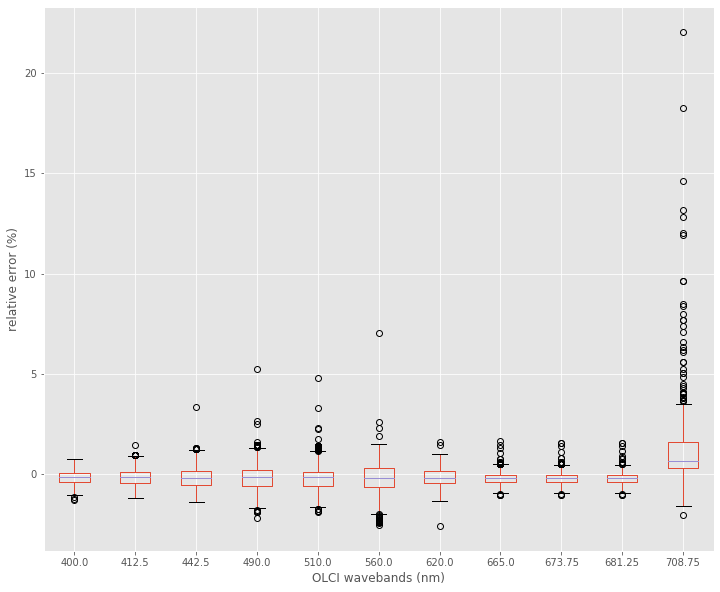

In [126]:
#fig, ax = plt.subplots(6,2, figsize=(10,15))
ax = (deltas*100).boxplot();
ax.set_xlabel('OLCI wavebands (nm)')
ax.set_ylabel('relative error (%)')